## **Diagnosis of Presence of Heart Disease Based on Age, Cholesterol, And Resting Blood Pressure**

**Names:** Srijan Sanghera, Sharon Feng, Annie Wang, Mairin Leitch

### **Introduction**
Coronary artery disease (CAD) poses a significant health challenge, marked by the narrowing of coronary arteries, necessitating precise diagnostic tools for timely intervention and treatment (Detrano, et al.,1989). Traditionally, invasive procedures like angiography have been employed for diagnosis, but they come with inherent risks such as arterial injury, stroke, and radiation exposure (Mayo Clinic, 2021). Recognizing the imperative for safer alternatives, there is an increasing interest in non-invasive diagnostic methods that leverage patient demographics and basic clinical information for CAD diagnosis. This data analysis aims to address this need by evaluating the diagnosis of the presence of heart disease using essential parameters: age, cholesterol levels, and resting blood pressure based on the database from the Hungarian Institute of Cardiology. <br> 

**Research Question:** Will the new patient have heart disease or not based on their age, cholesterol, and resting blood pressure?

The dataset used for this report comes from the Hungarian Institute of Cardiology in Budapest. The data consists solely of numerical values. A total of 76 columns of data exist, but only 14 columns are used in the given data tables (Detrano et al., 1989). The 14 available columns are titled ‘age’, ‘sex’, ‘cp’, ‘trestbps’,  ‘chol’, ‘fbs’, ‘restecg’ , ‘thalach’, ‘exang’, ‘oldpeak’, ‘slope’, ‘ca’, ‘thal’, and ‘num’ (Detrano et al., 1989). For this data analysis, we have selected the variables ‘chol’, ‘tresbps’, and ‘age’ to predict ‘num.


<u>Column explanations</u> (TA Kevin Wang confirmed it won’t be included in the word count):
1. ‘Age’ represents the patient’s age in years.
2. ‘Tresbps’ represents the patient’s resting blood pressure in mm/Hg upon admission to the hospital.
3. ‘Chol’ represents serum cholesterol levels in mg/dL.
4. ‘Num’ indicates the presence of heart disease; where 1 indicates the presence of heart disease, and 0 indicates no heart disease. For this classification problem, this is the variable we want to predict (Detrano et al., 1989).


To predict the presence of heart disease (‘num’), ‘age’, ‘chol’, and ‘trestbps’ were selected as the predictor variables for this classification problem. Age was selected as a predictor variable, as risk of coronary heart disease (CHD) and other chronic illnesses increase with age (Benfante et al., 1989). Therefore, it is more likely for someone in their middle ages or elder years to be diagnosed with heart disease (Benfante et al., 1989). Additionally, ‘chol’ was selected, as increased levels of low density lipoprotein (LDL), or ‘bad’ cholesterol, in the blood accelerates the risk of a CHD diagnosis and atherosclerosis, which is the clogging and narrowing of arteries (Sharett et al., 2001). Lastly, ‘trestbps’ was selected, as sustained systolic blood pressure above 140 mm/Hg increases risk of heart disease and stroke (Bowling et al., 2019). Furthermore, older age, higher cholesterol levels, and higher blood pressure are strong predictors for the presence of heart disease. We hypothesize that these predictors will produce clear and accurate results when determining if a patient has heart disease or not. 

### **Method and Exploratory Analysis**

**Importing libraries:**
- Used library() to install tidyverse, tidymodels, and repr packages.
- Used install.packages() to install “kknn” . 


In [2]:
#import packages:
library(tidyverse) 
library(tidymodels)
library(repr)
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



**Wrangling Data:**
- Loaded and renamed columns of the "processed.hungary.data" dataset.
- Cleaned and wrangled data: select predictive variables, filter out missing data, and correct data types.
- Splitted data into training (75%) and testing (25%) sets.



In [3]:
#loading data in:
URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
heart <- read_delim(URL, delim = ",", col_names = FALSE) |>
        rename(age = X1, sex = X2, cp = X3, trestbps = X4, chol = X5, fbs = X6, restecg = X7, thalach = X8, exang = X9,
               oldpeak = X10, slope = X11, ca = X12, thal = X13, num_predicted = X14)

#Cleaning and wrangling data:
heart_data <- heart |>
    select(age, chol, trestbps, num_predicted) |>
    filter(chol != "?", trestbps != "?") |>
    mutate(num_predicted = as.factor(num_predicted),
           num_predicted = fct_recode(num_predicted, "present" = "1", "absent" = "0"),
           chol = as.numeric(chol),
           trestbps = as.numeric(trestbps))
print("Table 1. Heart Disease Predictors and Class of Interest")

head(heart_data)
#split data into training and testing: 
set.seed(1111) 
heart_split <- initial_split(heart_data, prop = 0.75, strata = num_predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1. Heart Disease Predictors and Class of Interest"


age,chol,trestbps,num_predicted
<dbl>,<dbl>,<dbl>,<fct>
28,132,130,absent
29,243,120,absent
30,237,170,absent
31,219,100,absent
32,198,105,absent
32,225,110,absent


**Preliminary Exploratory Analysis (summary):**
- Use dplyr to summarize training data based on disease presence or absence.
- Compute counts and descriptive statistics for age, cholesterol, and blood pressure.
- Handle missing data: calculate and display the number of removed missing values.


In [4]:
#Summarize:
disease_vs_healthy <- heart_train |>
    group_by(num_predicted) |>
    summarize(count = n(), 
              min_age = min(age), max_age = max(age), mean_age = mean(age),
              min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),
              min_trestbsp = min(trestbps), max_trestbps = max(trestbps), mean_trestbps = mean(trestbps))
print("Table 2. Summary of the Training Data Based on Absence or Presence of Disease")
disease_vs_healthy

NA_summary <- heart |>
    group_by(num_predicted) |>
    summarize(total_age_NA_deleted = sum(age == "?"),
              total_chol_NA_deleted = sum(chol == "?"),
              total_trestbps_NA_deleted = sum(trestbps == "?"))
print("Table 3. Total Number of NA's Removed From Each Predictor Column (0 = Absence of Disease, 1 = Presence of Disease)")
NA_summary

[1] "Table 2. Summary of the Training Data Based on Absence or Presence of Disease"


num_predicted,count,min_age,max_age,mean_age,min_chol,max_chol,mean_chol,min_trestbsp,max_trestbps,mean_trestbps
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
absent,126,28,62,47.55556,85,468,240.5556,98,190,130.3175
present,75,31,65,49.62667,117,603,268.9067,92,200,135.2400


[1] "Table 3. Total Number of NA's Removed From Each Predictor Column (0 = Absence of Disease, 1 = Presence of Disease)"


num_predicted,total_age_NA_deleted,total_chol_NA_deleted,total_trestbps_NA_deleted
<dbl>,<int>,<int>,<int>
0,0,18,1
1,0,5,0


**Visualization of Training Data:**
- Create scatter plots (using ggplot() and geom_point()) with color-coded points based on heart disease presence.
- Age vs. Serum Cholesterol (Figure 1)
- Age vs. Resting Blood Pressure (Figure 2)
- Serum Cholesterol vs. Resting Blood Pressure (Figure 3)


[1] "Figure 1. Scatter Plot of Predictors Age vs. Serum Cholesterol. Presence and absense of disease are color coded"


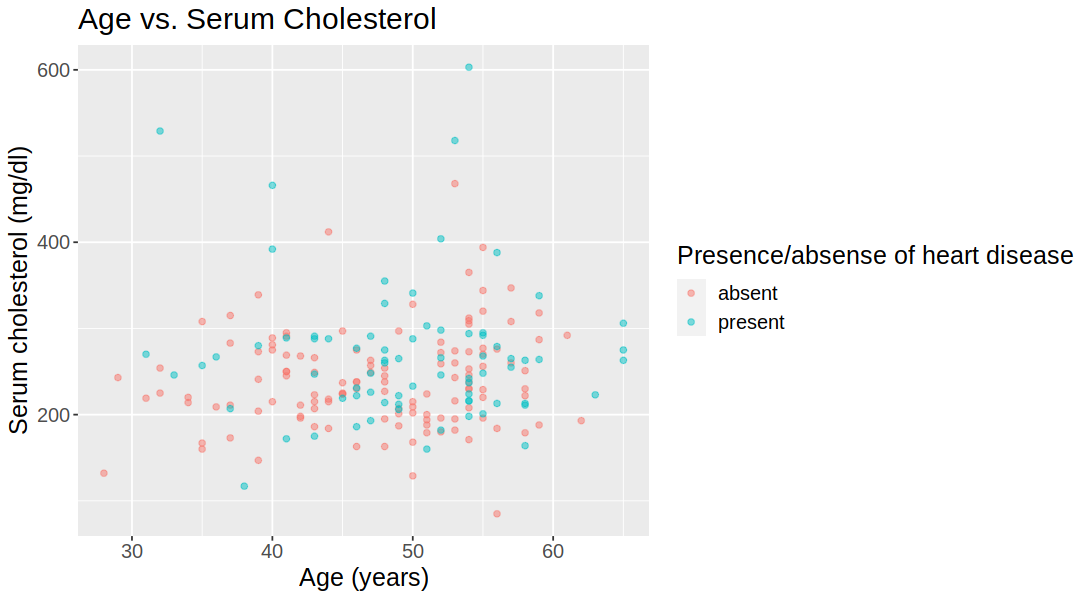

[1] "Figure 2. Scatter Plot of Predictors Age vs. Resting Blood Pressure. Presence and absense of disease are color coded"


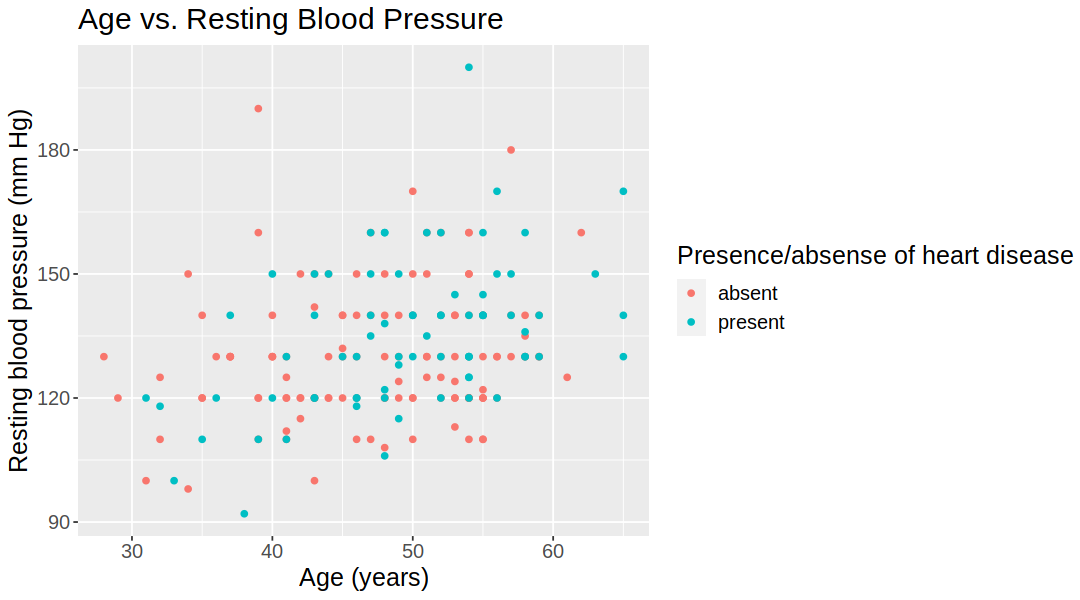

[1] "Figure 3. Scatter Plot of Predictors Serum Cholesterol vs. Resting Blood Pressure."
[1] "          Presence and absence of disease are color coded"


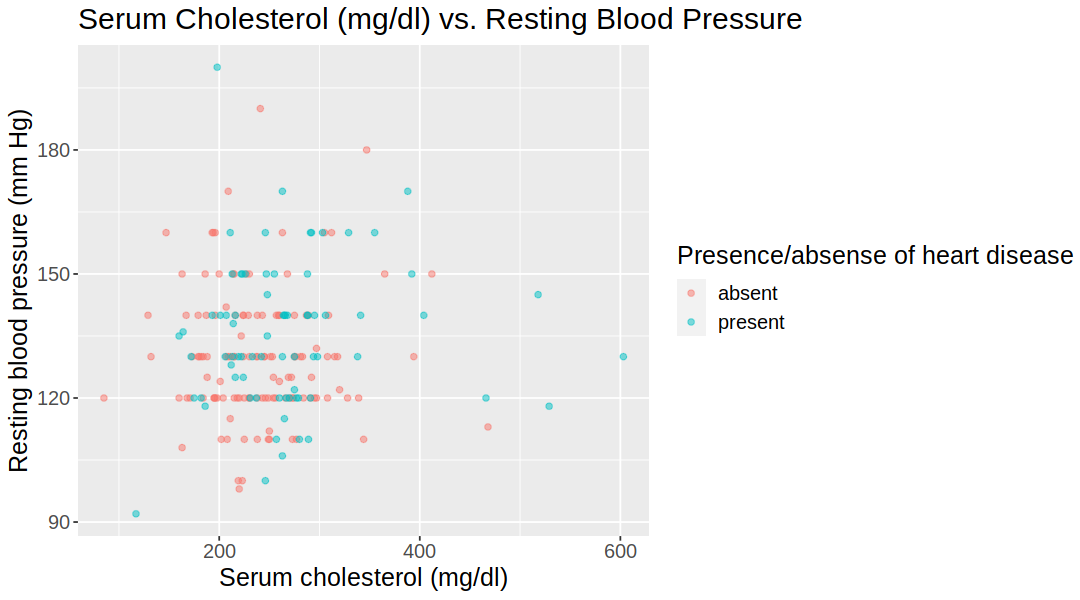

In [5]:
#visualising training data
options(repr.plot.width = 9, repr.plot.height = 5) 


# Visualizing Age vs. Serum Cholesterol
age_vs_cholesterol <- heart_train |>
    ggplot(aes(x = age, y = chol, color = num_predicted)) +
    geom_point(alpha = 0.5) +
    labs(x = "Age (years)", y = "Serum cholesterol (mg/dl)", color = "Presence/absense of heart disease") +
    ggtitle("Age vs. Serum Cholesterol") +
    theme(text = element_text(size=15))
age_vs_cholesterol
print("Figure 1. Scatter Plot of Predictors Age vs. Serum Cholesterol. Presence and absense of disease are color coded")

# Visualizing Age vs. Resting Blood Pressure
age_vs_trestbps <- heart_train |>
    ggplot(aes(x = age, y = trestbps, color = num_predicted)) +
    geom_point() +
    labs(x = "Age (years)", y = "Resting blood pressure (mm Hg)", color = "Presence/absense of heart disease") +
    ggtitle("Age vs. Resting Blood Pressure") +
    theme(text = element_text(size=15))
age_vs_trestbps
print("Figure 2. Scatter Plot of Predictors Age vs. Resting Blood Pressure. Presence and absense of disease are color coded")

# Visualizing Serum Cholesterol (mg/dl) vs. Resting Blood Pressure
chol_vs_trestbps <- heart_train |>
    ggplot(aes(x = chol, y = trestbps, color = num_predicted)) +
    geom_point(alpha = 0.5) +
    labs(x = "Serum cholesterol (mg/dl)", y = "Resting blood pressure (mm Hg)", color = "Presence/absense of heart disease") +
    ggtitle("Serum Cholesterol (mg/dl) vs. Resting Blood Pressure") +
    theme(text = element_text(size=15))
chol_vs_trestbps
print("Figure 3. Scatter Plot of Predictors Serum Cholesterol vs. Resting Blood Pressure.")
print("          Presence and absence of disease are color coded")


**K-Selection for k-NN Model:**
- Create a recipe for feature scaling and centering.
- Define a k-NN model specification with tuning parameters.
- Employ 10-fold cross-validation with stratification.
- Specify k values from 1 to 30.
- Develop a workflow integrating the recipe and model.
- Tune hyperparameters, filter for accuracy metric, and visualize k-selection.


[1] "Table 4. Accuracy of The Classifier Across 10 folds Using K values from 1 to 30"


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4865915,10,0.02042948,Preprocessor1_Model01
2,accuracy,binary,0.4865915,10,0.02042948,Preprocessor1_Model02
3,accuracy,binary,0.5575063,10,0.02628530,Preprocessor1_Model03
4,accuracy,binary,0.5575063,10,0.02628530,Preprocessor1_Model04
5,accuracy,binary,0.5875815,10,0.03394191,Preprocessor1_Model05
6,accuracy,binary,0.5875815,10,0.03394191,Preprocessor1_Model06
7,accuracy,binary,0.6021053,10,0.03252870,Preprocessor1_Model07
8,accuracy,binary,0.6021053,10,0.03252870,Preprocessor1_Model08
9,accuracy,binary,0.6291604,10,0.02951028,Preprocessor1_Model09


[1] "Figure 4. Estimated Accuracy Plot For the CLassifier Based on K values 1 to 30"
[1] "          Highest accuracy (~65.2%) resulted from K = 17 and 18"


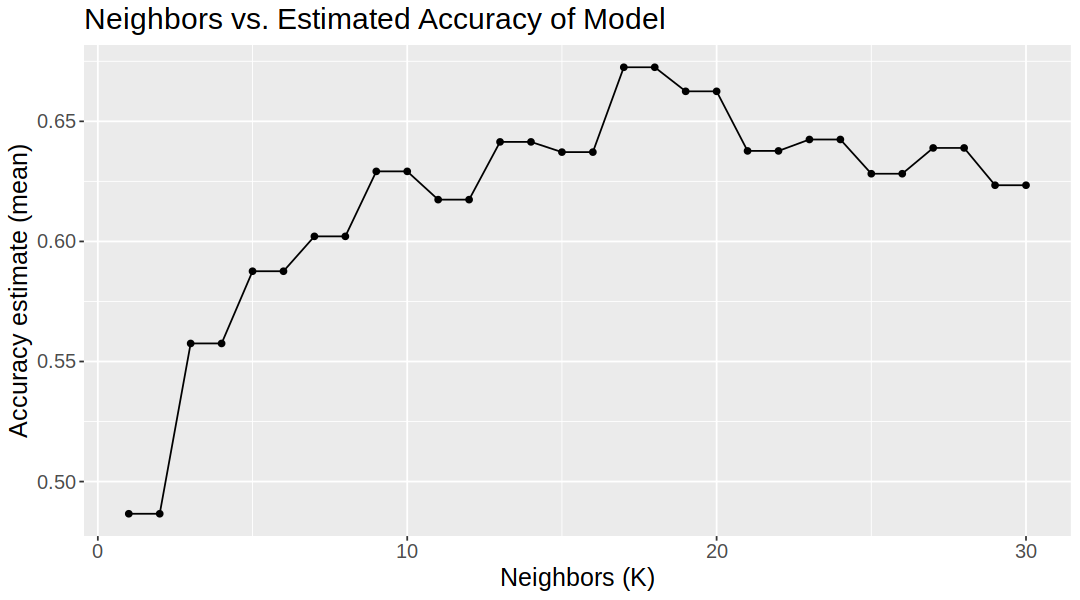

In [6]:
#Data analysis (Model)

#recipe:
heart_recipe <- recipe(num_predicted ~ age + chol + trestbps, data = heart_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#Selecting K:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

set.seed(444)
heart_vfold <- vfold_cv(heart_train, v = 10, strata = num_predicted)
k_vals <- tibble(neighbors = seq(from = 1, to = 30))

workflow_for_k_selection <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
print("Table 4. Accuracy of The Classifier Across 10 folds Using K values from 1 to 30") 
workflow_for_k_selection

k_plot <- ggplot(workflow_for_k_selection, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors (K)", y = "Accuracy estimate (mean)") +
    ggtitle("Neighbors vs. Estimated Accuracy of Model") +
    theme(text = element_text(size=15))
print("Figure 4. Estimated Accuracy Plot For the CLassifier Based on K values 1 to 30") 
print("          Highest accuracy (~65.2%) resulted from K = 17 and 18")
k_plot


**Heart Disease Classification Model:**
- Define a k-NN model specification with a fixed neighbor value (k = 17).
- Construct a workflow incorporating the recipe and the specified model.
- Fit the model to the training data.


In [8]:
#Heart disease classification model: 
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_workflow <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = heart_train)

**Model Testing:**
- Evaluate the trained model using the testing dataset.
- Generate predictions and combine them with the original testing dataset.
- Assess model accuracy and construct a confusion matrix.
- Summarize accuracy in Table 5 and display the confusion matrix in Table 6.


In [9]:
#Testing model with testing data:
heart_model_test <- predict(heart_workflow, heart_test) |>
    bind_cols(heart_test)

heart_model_accuracy <- heart_model_test |>
    metrics(truth = num_predicted, estimate = .pred_class) |>
        filter(.metric == "accuracy")
print("Table 5. Estimated Accuracy of The Classifier Based on The Testing Data Set")
heart_model_accuracy 

heart_model_mat <- heart_model_test |>
    conf_mat(truth = num_predicted, estimate = .pred_class)
print("Table 6. Confusion matrix Based on The Testing Data Set Where Truth = Actual Class of The Test Set")
print("         and Prediction = Predicted Class of The Test Set")
heart_model_mat 

#accuracy is ~65%

[1] "Table 5. Estimated Accuracy of The Classifier Based on The Testing Data Set"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6521739


[1] "Table 6. Confusion matrix Based on The Testing Data Set Where Truth = Actual Class of The Test Set"
[1] "         and Prediction = Predicted Class of The Test Set"


          Truth
Prediction absent present
   absent      38      19
   present      5       7

### **Discussion**

**Summary** <br>
We created a predictive model using K-Nearest Neighbors (KNN) classification of factors - age, cholesterol and resting blood pressure to predict whether a patient has a heart disease diagnosis. Our model had an accuracy of 65.2%, indicating that there is a favourable amount of correlation between the predictors and the patient having a heart disease.

**Findings and Expected Findings** <br>
Based on the initial scatterplots of our predictor variables, we expected to find a positive relationship between our predictor values (blood pressure, cholesterol levels, age) and the presence of heart disease.​ As per the introduction, the chosen factors were known to cause heart disease based on peer-reviewed literature. As referenced in the introduction, we expected cholesterol and the presence of heart disease to be positively correlated. Where there is a causal relationship between both, academic research also indicates the same. Our model’s accuracy of 65.2% suggests similar results, however, it is not precise. Models that predict crucial things like the diagnosis of heart disease need to be very accurate because a misdiagnosis can be fatal. Therefore, the model isn't ideal to be implemented right now. This can be attributed to the lack of usable data in the dataset. A lot of the values had to be removed because it was missing or unreliable. Hence, the accuracy of the model can be improved if more data can be procured or if the region for the study is expanded. We can also improve the model by prioritizing recall, which puts emphasis on correct true positives and minimises false negatives. Our predictions were in line with our expectations that a high degree of serum cholesterol, high blood pressure and the patient being relatively old contributes to the patient being more likely to be diagnosed with a hard disease.

**Impact of the Findings** <br>
Understanding the relationship between the presence of heart disease and Age, Cholesterol, and Resting Blood Pressure would play a crucial role in helping in diagnosing a patient. A classification model to predict heart disease can help doctors in the early detection of heart disease in patients. This model takes into account various indicators that are generally known to cause heart disease. Therefore, while using this model, doctors can advise changes in lifestyle for at-risk patients. Since having high accuracy is important in making such diagnoses, our model should be used as a supplementary tool to make a diagnosis. Doctors may not completely rely on the model to make their decision as the accuracy is not high enough for this task, but they can consider the results from this model while making a diagnosis. To make the model more accurate, individual factors could be weighted depending on how likely someone is to get a heart disease based on that factor.

**Future Questions**
Based on our results and the impact of our findings, the questions listed below can provide new avenues of research for this topic. 
- Which factors contribute more towards a patient being diagnosed with a heart disease?

To answer this question, forward selection can be used to identify predictors that produce the highest accuracy (Timbers et al., 2023). Forward selection is a method that allows one to test the classification model with all the available predictors (Timbers et al., 2023). The model starts with 0 predictors, then 1 is used, then 2 are used, and so on. After all the predictors are used, then the accuracies of the resulting models are compared (Timbers et al., 2023). The model with the highest accuracy then replaces the model used to answer the predictive question (Timbers et al., 2023). This may be a lengthy process for this analysis, since the dataset used has 14 possible variables. However, forward selection can help find future combinations of predictors that produce higher model accuracy. 

Below are further questions about different potential uses of the model, and about different populations.

- Can the model be used to predict specific heart conditions instead of just predicting the presence of heart disease?
- Does the model work for a larger population than that of Hungary’s?
- What differences exist between populations of different regions in terms of lifestyle and health?


### **References**

Benfante, R. J., Reed, D. M., MacLean, C. J., & Yano, K. (1989). Risk factors in middle age that predict early and late onset of coronary heart disease. Journal of Critical Epidemiology, 42(2), 95-104. https://doi.org/10.1016/0895-4356(89)90082-6

Bowling, C. B., Davis, B. R., Luciano, A., Simpson, L. M., Sloane, R., Peiper, C. F., Einhorn, P. T., Oparil, S., & Muntner, P. (2019). Sustained blood pressure control and coronary heart disease, stroke, heart failure, and mortality: An observational analysis of ALLHAT. The Journal of Critical Hypertension, 21(4), 451-459. https://doi.org/10.1111/jch.13515

Detrano, R., Janosi. A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 304-310.  

Mayo Clinic. (2021, December 14). Coronary angiogram. Mayo Clinic. https://www.mayoclinic.org/tests-procedures/coronary-angiogram/about/pac-20384904

Sharett, A. R., Ballantyne, C. M., Coady, S. A., Heiss, G., Sorlie, P. D., Catellier, D., & Patsch, W. (2001). Coronary heart disease prediction from lipoprotein cholesterol levels, triglycerides, lipoprotein(a), apolipoproteins A-I and B, and HDL density subfractions: The atherosclerosis risk in communities (ARIC) study. Circulation, 104(10), 1108-1113. https://oce.ovid.com/article/00003017-200109040-00009/HTML

Timbers, T., Campbell, T., & Lee, M. (2023). Data science: A first introduction. CRC Press. 